In [1]:
import os
import sys
sys.path.append('/home/liuzhenlong/MIA/MLHospital/mlh/')
sys.path.append('/home/liuzhenlong/MIA/MLHospital/mlh/defenses')
import matplotlib.pyplot as plt
import torchvision
from defenses.membership_inference.AdvReg import TrainTargetAdvReg
from defenses.membership_inference.DPSGD import TrainTargetDP
from defenses.membership_inference.LabelSmoothing import TrainTargetLabelSmoothing
from defenses.membership_inference.MixupMMD import TrainTargetMixupMMD
from defenses.membership_inference.PATE import TrainTargetPATE
from defenses.membership_inference.Normal import TrainTargetNormal

from defenses.membership_inference.logit_norm import TrainTargetLogitsNorm


from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from data_preprocessing.data_loader import GetDataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import argparse
import numpy as np
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)
torch.set_num_threads(1)




/data/anaconda3/envs/ml-hospital/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


name: zzz2
age: 19 weight: 58
lzl3
55


name: zzz2
age: 25 weight: 58


In [154]:
class Admin(User):
    def __init__(self,weight,name='zzz2',age=20):
        super().__init__(name,age)#因为此处要用父类的sex初值，所以就无须提供sex的值了
        self.weight = weight
    def show(self):
        print('name:', self.name)
        print('age:',self.age, 'weight:',self.weight)
a1=Admin(88,name='abc',age=11)

AA= User(name ='lzl',age =18)
print(AA.age)
AA.show()
BB= User()
BB.show()

print(BB.info)


a1=Admin(88,name='abc',age=11)
a2=Admin('abc2',11)
a3=Admin(weight=58)

print(a1.sex)
a1.show()
a2.show()
a3.show()
a3.info =89
print(a3.info)

18
name: lzl
age: 18 sex: f
name: zzz
age: 19 sex: f
25
f
name: abc
age: 11 weight: 88
name: 11
age: 20 weight: abc2
name: zzz2
age: 20 weight: 58
89


In [2]:
def parse_args(config_list):
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--batch-size', type=int, default=512,
                        help='batch_size')
    parser.add_argument('--num-workers', type=int, default=10,
                        help='num of workers to use')

    parser.add_argument('--training_type', type=str, default="Normal",
                        help='Normal, LabelSmoothing, AdvReg, DP, MixupMMD, PATE')
    parser.add_argument('--mode', type=str, default="shadow",
                        help='target, shadow')

    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs')
    parser.add_argument('--gpu', type=int, default=0,
                        help='gpu index used for training')

    # model dataset
    parser.add_argument('--model', type=str, default='resnet18')
    parser.add_argument('--load-pretrained', type=str, default='no')
    parser.add_argument('--task', type=str, default='mia',
                        help='specify the attack task, mia or ol')
    parser.add_argument('--dataset', type=str, default='CIFAR10',
                        help='dataset')
    parser.add_argument('--num-class', type=int, default=10,
                        help='number of classes')
    parser.add_argument('--inference-dataset', type=str, default='CIFAR10',
                        help='if yes, load pretrained the attack model to inference')
    parser.add_argument('--data-path', type=str, default='../datasets/',
                        help='data_path')
    parser.add_argument('--input-shape', type=str, default="32,32,3",
                        help='comma delimited input shape input')
    parser.add_argument('--log_path', type=str,
                        default='./save', help='data_path')
    # 默认储存到save里 
    

    args = parser.parse_args(args= config_list)

    args.input_shape = [int(item) for item in args.input_shape.split(',')]
    args.device = 'cuda:%d' % args.gpu if torch.cuda.is_available() else 'cpu'

    return args

In [3]:
import argparse

parser = argparse.ArgumentParser(description='test')

parser.add_argument('--sparse', action='store_true', default=False, help='GAT with sparse version or not.')
parser.add_argument('--seed', type=int, default=72, help='Random seed.')
parser.add_argument('--epochs', type=int, default=10000, help='Number of epochs to train.')




args = parser.parse_args(args=['--seed', '0',  '--sparse'])
print(args.sparse)

args = parser.parse_args(args=['--seed', '0'])

print(args.sparse)
print(args.seed)
print(args.epochs)


True
False
0
10000


In [4]:
opt = parse_args(['--mode', 'target'])


In [158]:
s = GetDataLoader(opt)
target_train_loader, target_inference_loader, target_test_loader, shadow_train_loader, shadow_inference_loader, shadow_test_loader = s.get_data_supervised()


add simple data augmentation!
add simple data augmentation!
Files already downloaded and verified
Files already downloaded and verified
Preparing dataloader!
dataset:  60000
target_train: 10000 	 target_inference: 10000 	 target_test: 10000


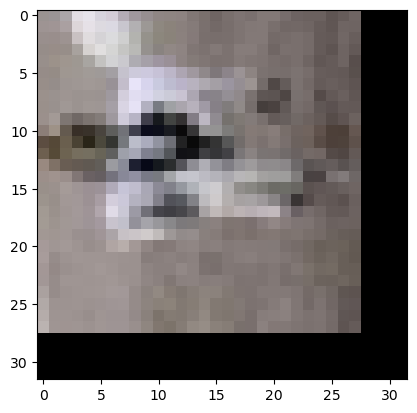

Label: 7


In [159]:


train_features, train_labels= next(iter(target_train_loader))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [160]:

from data_preprocessing import configs
type(configs.SUPPORTED_IMAGE_DATASETS_ATTRIBUTE_INFERENCE)

set

In [167]:
if opt.mode == "target":
        train_loader, inference_loader, test_loader = target_train_loader, target_inference_loader, target_test_loader
        
        # train_loader is a dataloader, using next(), feature shape is [128,3,32,32], label shape [128]
    # 
elif opt.mode == "shadow":
    train_loader, inference_loader, test_loader = shadow_train_loader, shadow_inference_loader, shadow_test_loader
else:
    raise ValueError("opt.mode should be target or shadow")

In [162]:
def get_target_model(name="resnet18", num_classes=10):
    if name == "resnet18":
        model = torchvision.models.resnet18()
        model.fc = nn.Sequential(nn.Linear(512, 10))
        # 代码修改了ResNet-18模型的最后一层全连接层，将其替换为一个新的全连接层nn.Linear(512, 10)，
        # 其中512是ResNet-18模型中最后一个卷积层的输出通道数，10是类别数量。这样做是为了将模型的输出调整为与任务中的类别数量相匹配。
    else:
        raise ValueError("Model not implemented yet :P")
    return model


def evaluate(args, model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(args.device), labels.to(args.device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    model.train()
    return correct / total

In [163]:
target_model = get_target_model(name="resnet18", num_classes=10)

save_pth = f'{opt.log_path}2/{opt.dataset}/{opt.training_type}/{opt.mode}'

In [164]:
f'{opt.log_path}2/{opt.dataset}/{opt.training_type}/{opt.mode}'

'./save2/CIFAR10/Normal/target'

In [166]:
img = train_features
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.to(device)
target_model(img).shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [45]:
total_evaluator = TrainTargetNormal(
            model=target_model, epochs=opt.epochs, log_path=save_pth)
total_evaluator.train(train_loader, test_loader)

Train Epoch: 1, Total Sample: 10000, Train Acc: 31.910, Test Acc: 30.960, Total Time: 8.010s
Train Epoch: 2, Total Sample: 10000, Train Acc: 37.250, Test Acc: 35.890, Total Time: 13.756s
Train Epoch: 3, Total Sample: 10000, Train Acc: 41.660, Test Acc: 39.960, Total Time: 19.496s
Train Epoch: 4, Total Sample: 10000, Train Acc: 45.250, Test Acc: 42.600, Total Time: 25.178s
Train Epoch: 5, Total Sample: 10000, Train Acc: 35.050, Test Acc: 33.450, Total Time: 30.889s
Train Epoch: 6, Total Sample: 10000, Train Acc: 47.960, Test Acc: 44.400, Total Time: 36.579s
Train Epoch: 7, Total Sample: 10000, Train Acc: 49.860, Test Acc: 46.930, Total Time: 42.296s
Train Epoch: 8, Total Sample: 10000, Train Acc: 36.120, Test Acc: 34.400, Total Time: 48.008s
Train Epoch: 9, Total Sample: 10000, Train Acc: 56.720, Test Acc: 51.240, Total Time: 53.736s
Train Epoch: 10, Total Sample: 10000, Train Acc: 49.010, Test Acc: 45.790, Total Time: 59.501s
Train Epoch: 11, Total Sample: 10000, Train Acc: 49.430, Tes